In [1]:
#2nd model
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('dark_background')

# Parameters
L = 4000
hbar = 1
x0 = 200 
k0_values = [0.0, 0.1, 0.2] 
E_values = np.sin(k0_values)
dt = 0.05
sigma = 20 
frames = 70000
x = np.arange(L)
dx = 1
a = 700
t_max = 2
x_horizon = 1500 + a*np.arctanh(1/t_max) # Horizon position
horizon_interaction_width = 50  # Spatial width around horizon for interaction
dwell_threshold = 50  # Distance from horizon to consider "dwelling"

results = {} # Storage for results for all k0 values
colors = ['cyan', 'lime', 'magenta']

In [2]:
#Main Simulation Loop for each k0
for k0 in k0_values:
    psi = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * k0 * (x - x0)) # Initial wavefunction
    psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))  # Normalize
    
    # Storage for current k0
    x_c_list = []  # Wave packet center (numerical)
    time_list = []
    probability_list = []
    vg_analytical_list = []  # Theoretical prediction
    vg_num_list = []   # Numerical (actual)
    mean_k_list = []  # Track momentum evolution
    delta_k_list = []  # Track momentum spread
    width_list = []  # Wave packet width Δx(t)
    
    # Dwell time tracking
    in_dwell_region = False
    dwell_start_time = None
    dwell_end_time = None
    dwell_entries = []  # Track all entries/exits
    current_dwell_start = None
    
    # RK4 integration
    for frame in range(frames):
        current_time = frame * dt
        
        # Track wave packet center
        total_density = np.abs(psi)**2
        x_c = np.sum(x * total_density) / np.sum(total_density)
        x_c_list.append(x_c)
        time_list.append(current_time)
        
        # Track total probability
        total_prob = np.sum(np.abs(psi)**2) * dx
        probability_list.append(total_prob)

        # Variance and width
        x_squared_avg = np.sum(x**2 * total_density) / np.sum(total_density)
        x_avg_squared = x_c**2
        variance = x_squared_avg - x_avg_squared
        width = np.sqrt(variance) if variance > 0 else 0

        width_list.append(width)
        
        # Track dwell time at horizon
        distance_to_horizon = abs(x_c - x_horizon)
        
        if distance_to_horizon < dwell_threshold:
            if not in_dwell_region: # Inside dwell region
                in_dwell_region = True # Just entered dwell region
                current_dwell_start = current_time
                if dwell_start_time is None:
                    dwell_start_time = current_time  # First entry
        else:
            if in_dwell_region: # Outside dwell region
                in_dwell_region = False # Just exited dwell region
                dwell_end_time = current_time  # Last exit
                if current_dwell_start is not None:
                    dwell_entries.append((current_dwell_start, current_time))
                    current_dwell_start = None

        if len(x_c_list) > 1:
            vg_num = (x_c_list[-1] - x_c_list[-2]) / dt
            vg_num_list.append(vg_num)
        
        V_norm = np.tanh((x0 - x_horizon)/a)  # normalization factor
        V = t_max * (np.tanh((x - x_horizon)/a) - V_norm) / (1 - V_norm) # Tilt profile
        alpha = (1 - V)
        beta = hbar**2 * (1/8 + V/6)

        # Analytical v_g at wave packet position
        # Get mean momentum from Fourier space
        psi_k = np.fft.fft(psi)
        k_grid = 2*np.pi*np.fft.fftfreq(L, dx)
        mean_k = np.sum(k_grid * np.abs(psi_k)**2) / np.sum(np.abs(psi_k)**2)
        
        # Evaluate V at the wave packet center
        V_at_xc = t_max * (np.tanh((x_c - x_horizon)/a) - V_norm) / (1 - V_norm)
        alpha_at_xc = 1 - V_at_xc
        beta_at_xc = hbar**2 * (1/8 + V_at_xc/6)
        
        # Track momentum spread (standard deviation)
        mean_k_squared = np.sum(k_grid**2 * np.abs(psi_k)**2) / np.sum(np.abs(psi_k)**2)
        delta_k = np.sqrt(mean_k_squared - mean_k**2)

        # Track skewness to detect asymmetry
        mean_k_cubed = np.sum(k_grid**3 * np.abs(psi_k)**2) / np.sum(np.abs(psi_k)**2)
        skewness = mean_k_cubed / (delta_k**3 + 1e-10)
        
        mean_k_list.append(mean_k)
        delta_k_list.append(delta_k)
        psi_k_density = np.abs(psi_k)**2
        
        # v_g from APPROXIMATE dispersion E ≈ (1-V)k + (1/8 + V/6)k³
        # v_g = dE/dk = (1-V) + 3(1/8 + V/6)k²
        v_g_approx_grid = alpha_at_xc + 3 * beta_at_xc * k_grid**2
        v_g_approx = np.sum(v_g_approx_grid * psi_k_density) / np.sum(psi_k_density)
        
        vg_analytical_list.append(v_g_approx)
        
        # RK4 integration
        # Stage 1: Compute k1
        dpsi_dx = np.zeros(L, dtype=complex)
        dpsi_dx[1:-1] = (psi[2:] - psi[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi[1] - psi[-1]) / (2 * dx)      # Periodic BC
        dpsi_dx[-1] = (psi[0] - psi[-2]) / (2 * dx)  

        d3psi_dx3 = np.zeros(L, dtype=complex)
        d3psi_dx3[2:-2] = (psi[4:] - 2*psi[3:-1] + 2*psi[1:-3] - psi[:-4]) / (2*dx**3)
        d3psi_dx3[0] = (psi[2] - 2*psi[1] + 2*psi[-1] - psi[-2]) / (2*dx**3)
        d3psi_dx3[1] = (psi[3] - 2*psi[2] + 2*psi[0] - psi[-1]) / (2*dx**3)
        d3psi_dx3[-1] = (psi[1] - 2*psi[0] + 2*psi[-2] - psi[-3]) / (2*dx**3)
        d3psi_dx3[-2] = (psi[0] - 2*psi[-1] + 2*psi[-3] - psi[-4]) / (2*dx**3)

        k1 = -alpha * dpsi_dx + beta * d3psi_dx3

        # Stage 2: Compute k2
        psi_temp = psi + 0.5 * dt * k1
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        d3psi_dx3[2:-2] = (psi_temp[4:] - 2*psi_temp[3:-1] + 2*psi_temp[1:-3] - psi_temp[:-4]) / (2*dx**3)
        d3psi_dx3[0] = (psi_temp[2] - 2*psi_temp[1] + 2*psi_temp[-1] - psi_temp[-2]) / (2*dx**3)
        d3psi_dx3[1] = (psi_temp[3] - 2*psi_temp[2] + 2*psi_temp[0] - psi_temp[-1]) / (2*dx**3)
        d3psi_dx3[-1] = (psi_temp[1] - 2*psi_temp[0] + 2*psi_temp[-2] - psi_temp[-3]) / (2*dx**3)
        d3psi_dx3[-2] = (psi_temp[0] - 2*psi_temp[-1] + 2*psi_temp[-3] - psi_temp[-4]) / (2*dx**3)
        k2 = -alpha * dpsi_dx + beta * d3psi_dx3

        # Stage 3: Compute k3
        psi_temp = psi + 0.5 * dt * k2
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        d3psi_dx3[2:-2] = (psi_temp[4:] - 2*psi_temp[3:-1] + 2*psi_temp[1:-3] - psi_temp[:-4]) / (2*dx**3)
        d3psi_dx3[0] = (psi_temp[2] - 2*psi_temp[1] + 2*psi_temp[-1] - psi_temp[-2]) / (2*dx**3)
        d3psi_dx3[1] = (psi_temp[3] - 2*psi_temp[2] + 2*psi_temp[0] - psi_temp[-1]) / (2*dx**3)
        d3psi_dx3[-1] = (psi_temp[1] - 2*psi_temp[0] + 2*psi_temp[-2] - psi_temp[-3]) / (2*dx**3)
        d3psi_dx3[-2] = (psi_temp[0] - 2*psi_temp[-1] + 2*psi_temp[-3] - psi_temp[-4]) / (2*dx**3)
        k3 = -alpha * dpsi_dx + beta * d3psi_dx3

        # Stage 4: Compute k4
        psi_temp = psi + dt * k3
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        d3psi_dx3[2:-2] = (psi_temp[4:] - 2*psi_temp[3:-1] + 2*psi_temp[1:-3] - psi_temp[:-4]) / (2*dx**3)
        d3psi_dx3[0] = (psi_temp[2] - 2*psi_temp[1] + 2*psi_temp[-1] - psi_temp[-2]) / (2*dx**3)
        d3psi_dx3[1] = (psi_temp[3] - 2*psi_temp[2] + 2*psi_temp[0] - psi_temp[-1]) / (2*dx**3)
        d3psi_dx3[-1] = (psi_temp[1] - 2*psi_temp[0] + 2*psi_temp[-2] - psi_temp[-3]) / (2*dx**3)
        d3psi_dx3[-2] = (psi_temp[0] - 2*psi_temp[-1] + 2*psi_temp[-3] - psi_temp[-4]) / (2*dx**3)
        k4 = -alpha * dpsi_dx + beta * d3psi_dx3

        psi = psi + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4) # RK4 Update
        
        # Normalize occasionally - COMMENTED OUT for non-Hermitian evolution
        #if frame % 100 == 0:
        #    psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))
    
    if in_dwell_region and current_dwell_start is not None: # If still in dwell region at end, close the interval
        dwell_entries.append((current_dwell_start, current_time))
    
    total_dwell_time = sum([exit_t - enter_t for enter_t, exit_t in dwell_entries]) # Calculate total dwell time from all entries
    
    # Store results for this k0
    results[k0] = {
        'x_c_list': x_c_list,
        'time_list': time_list,
        'final_psi': psi.copy(),
        'dwell_time': total_dwell_time,
        'dwell_start': dwell_start_time,
        'dwell_end': dwell_end_time,
        'dwell_entries': dwell_entries,
        'still_dwelling': in_dwell_region,
        'probability_list': probability_list,
        'vg_num': vg_num_list,
        'vg_analytical': vg_analytical_list,  # Theory
        'mean_k': mean_k_list,
        'delta_k': delta_k_list,
        'width_list': width_list
    }

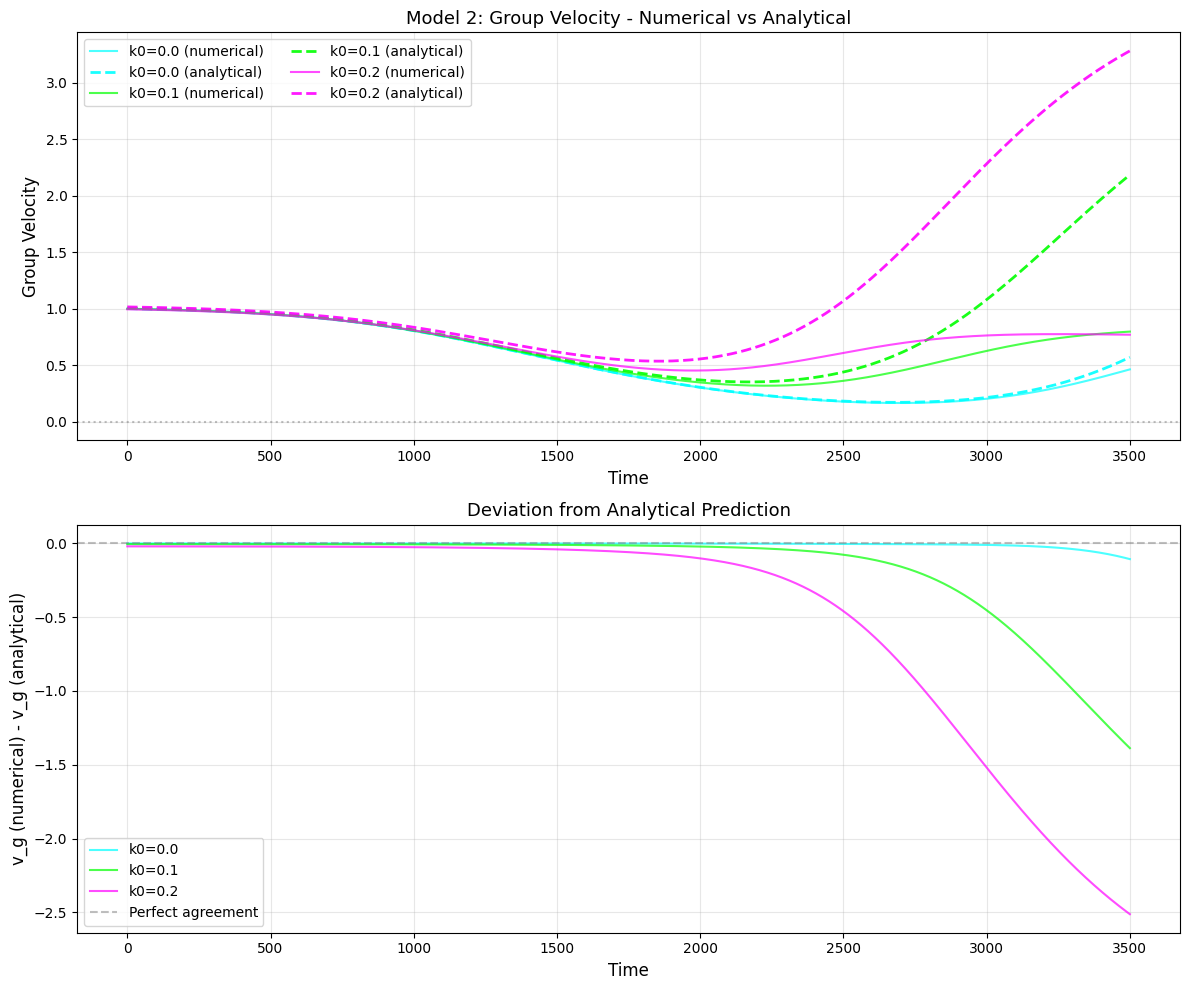


MODEL 2: GROUP VELOCITY COMPARISON SUMMARY

k0 = 0.0:
  Mean numerical v_g:    0.525492
  Mean analytical v_g:   0.533219
  Mean difference:       -0.007726
  RMS difference:        0.018374
  Max absolute diff:     0.107314
  Dwell time at horizon: 484.65

k0 = 0.1:
  Mean numerical v_g:    0.647389
  Mean analytical v_g:   0.817866
  Mean difference:       -0.170477
  RMS difference:        0.367783
  Max absolute diff:     1.387167
  Dwell time at horizon: 258.60

k0 = 0.2:
  Mean numerical v_g:    0.719923
  Mean analytical v_g:   1.202463
  Mean difference:       -0.482540
  RMS difference:        0.877048
  Max absolute diff:     2.511493
  Dwell time at horizon: 188.50


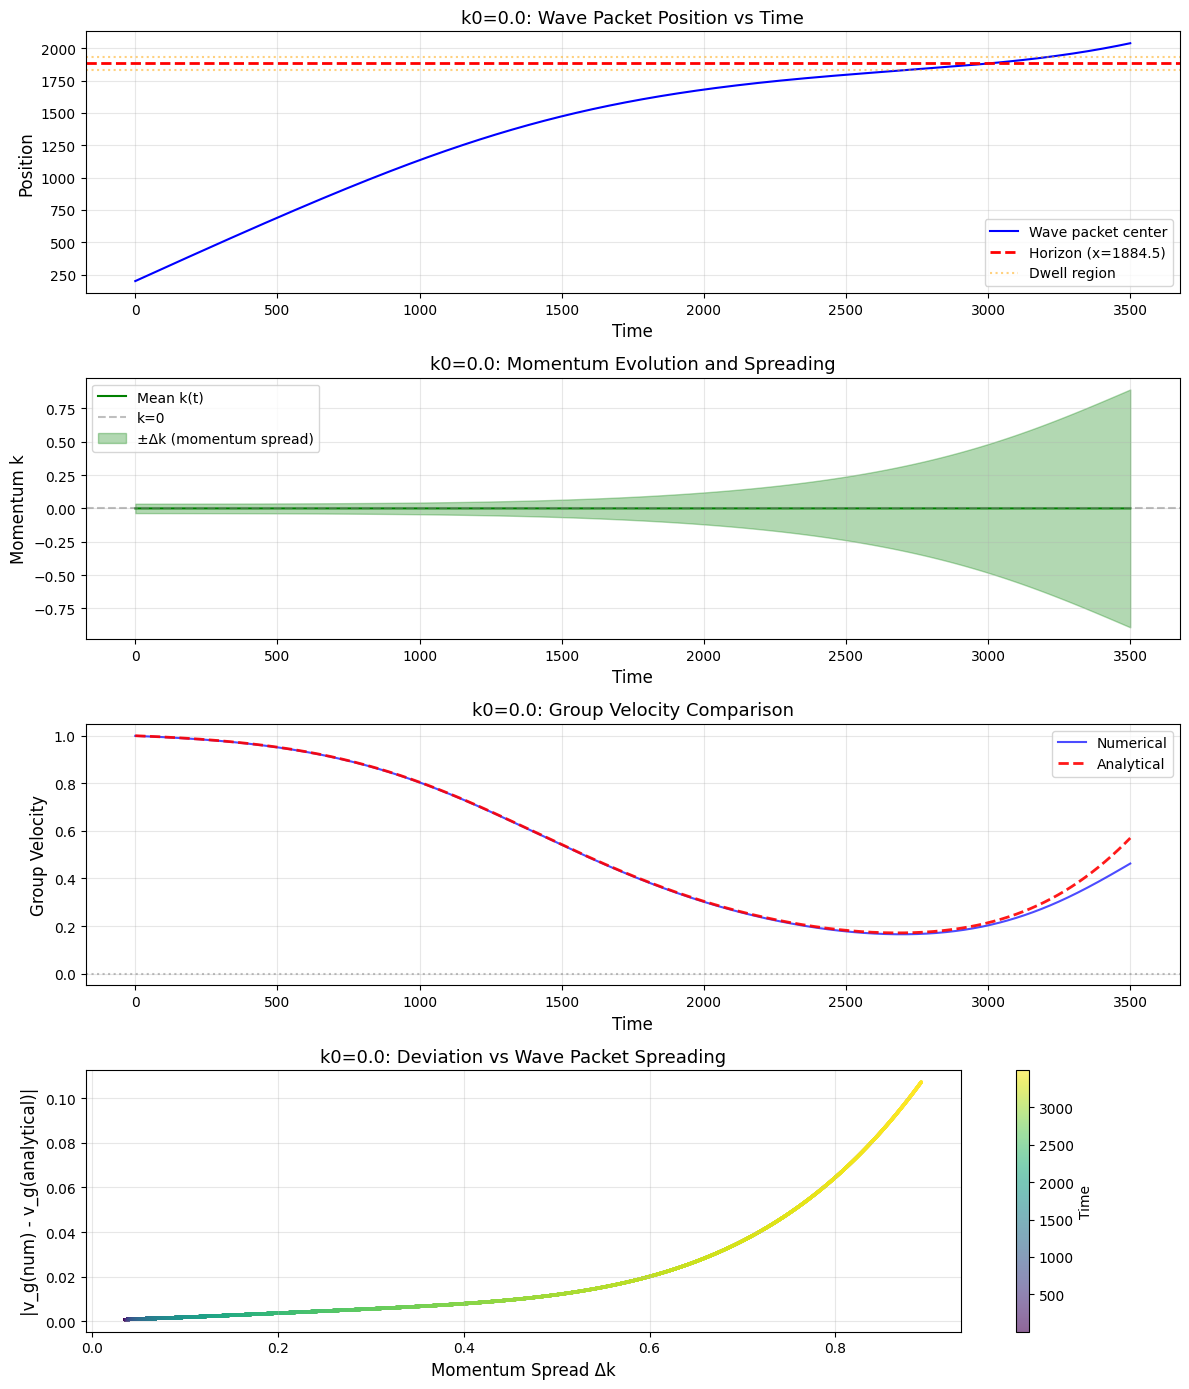


k0=0.0 SPECIAL CASE ANALYSIS
Initial position: x0 = 200
Horizon position: x_horizon = 1884.5
Final position: x_c = 2039.2
Distance traveled: 1839.2
Crossed horizon: YES

Momentum Evolution:
  Initial mean k: 0.000000
  Final mean k: 0.000000
  k drift: -0.000000
  Initial Δk: 0.035355
  Final Δk: 0.892594
  Δk growth: 25.25x

Semiclassical Validity Check:
  Criterion: Δk << |k₀| for narrow wave packet
  Initial: Δk/|k₀| = 353554205.98
  Final: Δk/|k₀| = 8925938577.94

Velocity Statistics:
  Mean numerical v_g: 0.525492
  Mean analytical v_g: 0.533219
  Final numerical v_g: 0.462820
  Final analytical v_g: 0.570134
  Final deviation: 0.107314


In [3]:
# Plot: Numerical vs Analytical Group Velocity
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

ax1 = axes[0]
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]  # Skip first (no numerical v_g)
    vg_num = results[k0]['vg_num']
    vg_analytical = results[k0]['vg_analytical'][1:]  # Match length
    
    ax1.plot(time_list, vg_num, color=colors[i], linewidth=1.5, 
             label=f'k0={k0} (numerical)', alpha=0.7)
    ax1.plot(time_list, vg_analytical, '--', color=colors[i], linewidth=2, 
             label=f'k0={k0} (analytical)', alpha=0.9)

ax1.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Group Velocity', fontsize=12)
ax1.set_title('Model 2: Group Velocity - Numerical vs Analytical', fontsize=13)
ax1.legend(fontsize=10, ncol=2)
ax1.grid(alpha=0.3)

# Plot: Difference (numerical - analytical)
ax2 = axes[1]
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]
    vg_num = np.array(results[k0]['vg_num'])
    vg_analytical = np.array(results[k0]['vg_analytical'][1:])
    
    difference = vg_num - vg_analytical
    ax2.plot(time_list, difference, color=colors[i], linewidth=1.5, 
             label=f'k0={k0}', alpha=0.7)

ax2.axhline(0, color='gray', linestyle='--', alpha=0.5, label='Perfect agreement')
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('v_g (numerical) - v_g (analytical)', fontsize=12)
ax2.set_title('Deviation from Analytical Prediction', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model2_vg_comparison.png', dpi=150)
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("MODEL 2: GROUP VELOCITY COMPARISON SUMMARY")
print("="*60)
for k0 in k0_values:
    vg_num = np.array(results[k0]['vg_num'])
    vg_analytical = np.array(results[k0]['vg_analytical'][1:])
    difference = vg_num - vg_analytical
    
    print(f"\nk0 = {k0}:")
    print(f"  Mean numerical v_g:    {np.mean(vg_num):.6f}")
    print(f"  Mean analytical v_g:   {np.mean(vg_analytical):.6f}")
    print(f"  Mean difference:       {np.mean(difference):.6f}")
    print(f"  RMS difference:        {np.sqrt(np.mean(difference**2)):.6f}")
    print(f"  Max absolute diff:     {np.max(np.abs(difference)):.6f}")
    print(f"  Dwell time at horizon: {results[k0]['dwell_time']:.2f}")

# Additional diagnostic plot for k0=0.0 case
fig2, axes2 = plt.subplots(4, 1, figsize=(12, 14))

k0_zero = 0.0
if k0_zero in results:
    time_list = np.array(results[k0_zero]['time_list'][1:])
    x_c_list = np.array(results[k0_zero]['x_c_list'][1:])
    vg_num = np.array(results[k0_zero]['vg_num'])
    vg_analytical = np.array(results[k0_zero]['vg_analytical'][1:])
    mean_k = np.array(results[k0_zero]['mean_k'][1:])
    delta_k = np.array(results[k0_zero]['delta_k'][1:])
    
    # Panel 1: Wave packet position
    ax_pos = axes2[0]
    ax_pos.plot(time_list, x_c_list, 'b-', linewidth=1.5, label='Wave packet center')
    ax_pos.axhline(x_horizon, color='red', linestyle='--', linewidth=2, 
                   label=f'Horizon (x={x_horizon:.1f})')
    ax_pos.axhline(x_horizon - dwell_threshold, color='orange', linestyle=':', alpha=0.5)
    ax_pos.axhline(x_horizon + dwell_threshold, color='orange', linestyle=':', alpha=0.5, 
                   label='Dwell region')
    ax_pos.set_xlabel('Time', fontsize=12)
    ax_pos.set_ylabel('Position', fontsize=12)
    ax_pos.set_title('k0=0.0: Wave Packet Position vs Time', fontsize=13)
    ax_pos.legend(fontsize=10)
    ax_pos.grid(alpha=0.3)
    
    # Panel 2: Momentum evolution
    ax_k = axes2[1]
    ax_k.plot(time_list, mean_k, 'g-', linewidth=1.5, label='Mean k(t)')
    ax_k.axhline(0, color='gray', linestyle='--', alpha=0.5, label='k=0')
    ax_k.fill_between(time_list, mean_k - delta_k, mean_k + delta_k, 
                      alpha=0.3, color='g', label='±Δk (momentum spread)')
    ax_k.set_xlabel('Time', fontsize=12)
    ax_k.set_ylabel('Momentum k', fontsize=12)
    ax_k.set_title('k0=0.0: Momentum Evolution and Spreading', fontsize=13)
    ax_k.legend(fontsize=10)
    ax_k.grid(alpha=0.3)
    
    # Panel 3: Group velocities
    ax_vg = axes2[2]
    ax_vg.plot(time_list, vg_num, 'b-', linewidth=1.5, label='Numerical', alpha=0.7)
    ax_vg.plot(time_list, vg_analytical, 'r--', linewidth=2, label='Analytical', alpha=0.9)
    ax_vg.axhline(0, color='gray', linestyle=':', alpha=0.5)
    ax_vg.set_xlabel('Time', fontsize=12)
    ax_vg.set_ylabel('Group Velocity', fontsize=12)
    ax_vg.set_title('k0=0.0: Group Velocity Comparison', fontsize=13)
    ax_vg.legend(fontsize=10)
    ax_vg.grid(alpha=0.3)
    
    # Panel 4: Deviation vs momentum spread
    ax_ratio = axes2[3]
    difference = vg_num - vg_analytical
    ax_ratio.scatter(delta_k, np.abs(difference), c=time_list, cmap='viridis', 
                    s=2, alpha=0.6, label='|Deviation|')
    ax_ratio.set_xlabel('Momentum Spread Δk', fontsize=12)
    ax_ratio.set_ylabel('|v_g(num) - v_g(analytical)|', fontsize=12)
    ax_ratio.set_title('k0=0.0: Deviation vs Wave Packet Spreading', fontsize=13)
    cbar = plt.colorbar(ax_ratio.collections[0], ax=ax_ratio, label='Time')
    ax_ratio.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model2_k0_zero_diagnostics.png', dpi=150)
    plt.show()
    
    print("\n" + "="*60)
    print("k0=0.0 SPECIAL CASE ANALYSIS")
    print("="*60)
    print(f"Initial position: x0 = {x0}")
    print(f"Horizon position: x_horizon = {x_horizon:.1f}")
    print(f"Final position: x_c = {x_c_list[-1]:.1f}")
    print(f"Distance traveled: {x_c_list[-1] - x0:.1f}")
    print(f"Crossed horizon: {'YES' if x_c_list[-1] > x_horizon else 'NO'}")
    print(f"\nMomentum Evolution:")
    print(f"  Initial mean k: {mean_k[0]:.6f}")
    print(f"  Final mean k: {mean_k[-1]:.6f}")
    print(f"  k drift: {mean_k[-1] - mean_k[0]:.6f}")
    print(f"  Initial Δk: {delta_k[0]:.6f}")
    print(f"  Final Δk: {delta_k[-1]:.6f}")
    print(f"  Δk growth: {(delta_k[-1] / delta_k[0]):.2f}x")
    print(f"\nSemiclassical Validity Check:")
    print(f"  Criterion: Δk << |k₀| for narrow wave packet")
    print(f"  Initial: Δk/|k₀| = {delta_k[0]/max(abs(mean_k[0]), 1e-10):.2f}")
    print(f"  Final: Δk/|k₀| = {delta_k[-1]/max(abs(mean_k[-1]), 1e-10):.2f}")
    print(f"\nVelocity Statistics:")
    print(f"  Mean numerical v_g: {np.mean(vg_num):.6f}")
    print(f"  Mean analytical v_g: {np.mean(vg_analytical):.6f}")
    print(f"  Final numerical v_g: {vg_num[-1]:.6f}")
    print(f"  Final analytical v_g: {vg_analytical[-1]:.6f}")
    print(f"  Final deviation: {abs(vg_num[-1] - vg_analytical[-1]):.6f}")

In [4]:
# Reflection/Transmission Analysis
T_values = []
R_values = []
Loss_values = []

for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    horizon_idx = np.argmin(np.abs(x - x_horizon)) # Find horizon index
    
    # Split regions at horizon
    transmission_region = x > x_horizon
    reflection_region = x < x_horizon
    
    # Calculate probabilities
    P_transmitted = np.sum(final_density[transmission_region]) * dx
    P_reflected = np.sum(final_density[reflection_region]) * dx
    P_total_final = P_transmitted + P_reflected
    
    P_initial = 1.0 # Initial probability (before evolution)
    
    # Proper Reflection/Transmission/Loss coefficients
    T = P_transmitted / P_initial
    R = P_reflected / P_initial
    Loss = 1.0 - (R + T)
    
    T_values.append(T)
    R_values.append(R)
    Loss_values.append(Loss)
    
    # Print results
    print(f"k0 = {k0:.1f}:")
    print(f"  Reflection (R) = {R:.6f}")
    print(f"  Transmission (T) = {T:.6f}")
    print(f"  Loss (1 - R - T) = {Loss:.6f}")
    print(f"  R + T + Loss = {R + T + Loss:.6f}")
    print(f"  Total probability (final) = {P_total_final:.6f}")
    print()

# Dwell Time Analysis
print(f"Dwell threshold: ±{dwell_threshold} from horizon (x_h = {x_horizon:.2f})")
print()

dwell_times = []
for k0 in k0_values:
    dwell_time = results[k0]['dwell_time']
    dwell_start = results[k0]['dwell_start']
    dwell_end = results[k0]['dwell_end']
    dwell_entries = results[k0]['dwell_entries']
    still_dwelling = results[k0]['still_dwelling']
    dwell_times.append(dwell_time)
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Total dwell time: {dwell_time:.2f}")
    print(f"  Number of horizon passages: {len(dwell_entries)}")
    
    if len(dwell_entries) > 0:
        for i, (enter_t, exit_t) in enumerate(dwell_entries):
            print(f"    Passage {i+1}: entered at t={enter_t:.2f}, exited at t={exit_t:.2f}, duration={exit_t-enter_t:.2f}")
    
    if dwell_start is None:
        print(f"  Never entered horizon region")
    
    if still_dwelling:
        print(f"  Still in horizon region at end of simulation")
    print()

k0 = 0.0:
  Reflection (R) = 0.009111
  Transmission (T) = 0.042385
  Loss (1 - R - T) = 0.948504
  R + T + Loss = 1.000000
  Total probability (final) = 0.051496

k0 = 0.1:
  Reflection (R) = 0.000190
  Transmission (T) = 0.148866
  Loss (1 - R - T) = 0.850944
  R + T + Loss = 1.000000
  Total probability (final) = 0.149056

k0 = 0.2:
  Reflection (R) = 0.000000
  Transmission (T) = 0.338769
  Loss (1 - R - T) = 0.661231
  R + T + Loss = 1.000000
  Total probability (final) = 0.338769

Dwell threshold: ±50 from horizon (x_h = 1884.51)

k0 = 0.0:
  Total dwell time: 484.65
  Number of horizon passages: 1
    Passage 1: entered at t=2732.15, exited at t=3216.80, duration=484.65

k0 = 0.1:
  Total dwell time: 258.60
  Number of horizon passages: 1
    Passage 1: entered at t=2430.05, exited at t=2688.65, duration=258.60

k0 = 0.2:
  Total dwell time: 188.50
  Number of horizon passages: 1
    Passage 1: entered at t=2229.90, exited at t=2418.40, duration=188.50



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


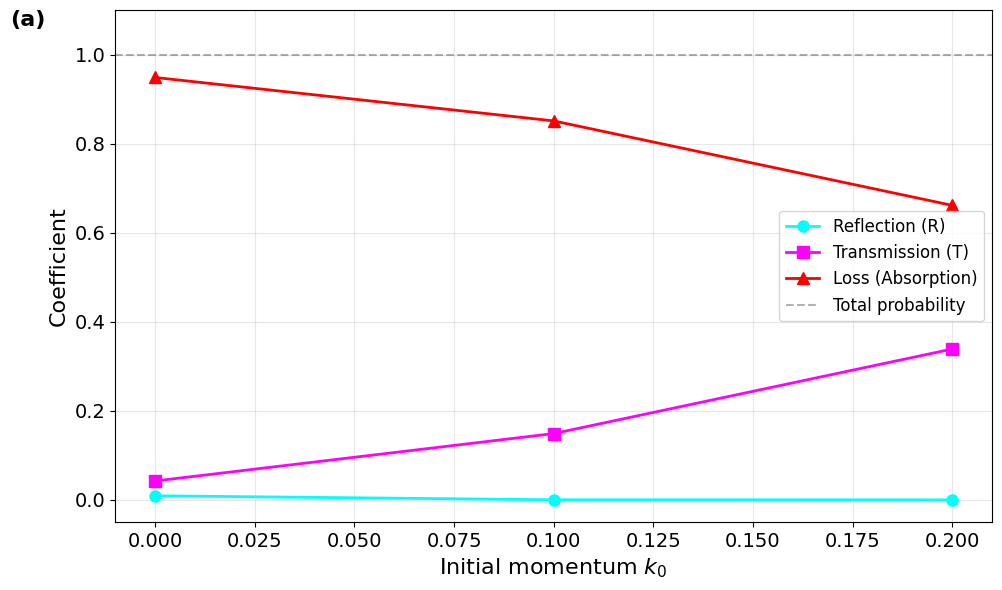

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


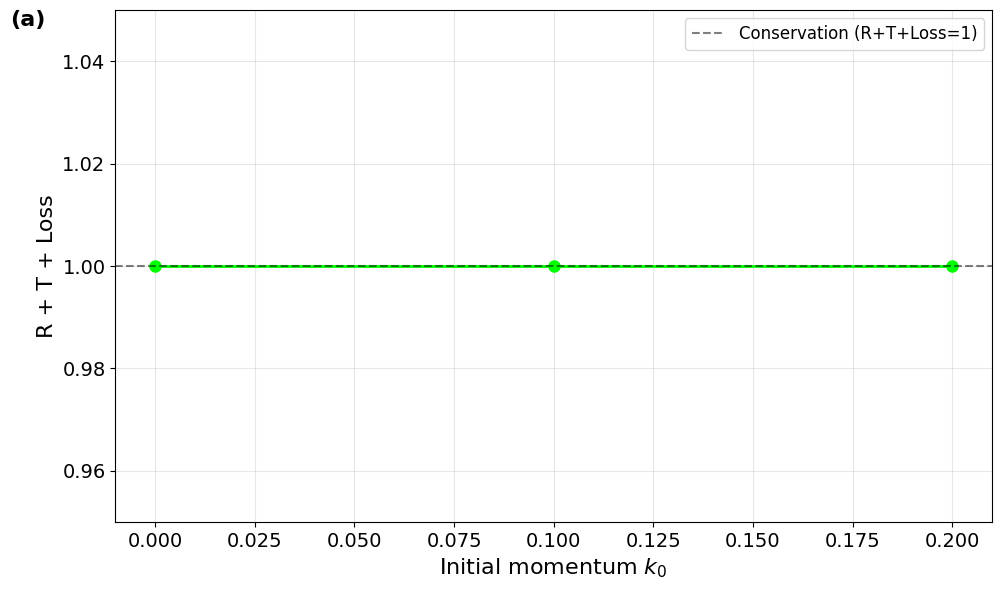

SCATTERING COEFFICIENTS DIAGNOSTICS - MODEL 2 (Tilt + Dispersion)
Simulation Parameters:
  L = 4000, x_horizon = 1884.51, frames = 70000, dt = 0.05
  Horizon width parameter a = 700
  Dispersion coefficients: β = ħ²(1/8 + V/6)
  Dwell threshold = ±50 from horizon

DETAILED SCATTERING ANALYSIS:
--------------------------------------------------
k0 = 0.0:
  Initial position: x = 200.0
  Final position:   x = 2039.2
  Net displacement: 1839.2

  PROBABILITY DISTRIBUTION (final):
    Reflection region (x < 1884.5): 0.009111 (0.91%)
    Transmission region (x > 1884.5): 0.042385 (4.24%)
    Near horizon (±50): 0.017815 (1.78%)
    Total probability: 0.051496

  SCATTERING COEFFICIENTS:
    Reflection (R)  = 0.009111
    Transmission (T) = 0.042385
    Loss (1-R-T)    = 0.948504
    R + T + Loss    = 1.000000

  HORIZON INTERACTION:
    Total dwell time: 484.65
    Number of horizon passages: 1
    Average dwell per passage: 484.65
    Maximum dwell per passage: 484.65

k0 = 0.1:
  Initial p

In [5]:
# Plot 1: R, T, and Loss vs k0
plt.figure(figsize=(10, 6))
plt.plot(k0_values, R_values, 'o-', color='cyan', linewidth=2, markersize=8, label='Reflection (R)')
plt.plot(k0_values, T_values, 's-', color='magenta', linewidth=2, markersize=8, label='Transmission (T)')
plt.plot(k0_values, Loss_values, '^-', color='red', linewidth=2, markersize=8, label='Loss (Absorption)')
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.3, label='Total probability')
plt.xlabel('Initial momentum $k_0$', fontsize=16)
plt.ylabel('Coefficient', fontsize=16)
#plt.title('Scattering Coefficients (Non-Hermitian System)\nModel 1 (Pure Tilt)', fontsize=13)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.ylim([-0.05, 1.1])
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.annotate('(a)', xy=(-0.12, 1.00), xycoords='axes fraction',
             fontsize=16, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.savefig('E2_scattering_coefficients.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# Plot 2: R + T + Loss (should equal 1)
plt.figure(figsize=(10, 6))
sum_all = np.array(R_values) + np.array(T_values) + np.array(Loss_values)
plt.plot(k0_values, sum_all, 'o-', color='lime', linewidth=2, markersize=8)
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Conservation (R+T+Loss=1)')
plt.xlabel('Initial momentum $k_0$', fontsize=16)
plt.ylabel('R + T + Loss', fontsize=16)
#plt.title('Total Probability Check', fontsize=13)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.ylim([0.95, 1.05])
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.annotate('(a)', xy=(-0.12, 1.00), xycoords='axes fraction',
             fontsize=16, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.savefig('E2_probability_conservation.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# Comprehensive Diagnostic Printout for Scattering Coefficients - MODEL 2
print("=" * 70)
print("SCATTERING COEFFICIENTS DIAGNOSTICS - MODEL 2 (Tilt + Dispersion)")
print("=" * 70)
print(f"Simulation Parameters:")
print(f"  L = {L}, x_horizon = {x_horizon:.2f}, frames = {frames}, dt = {dt}")
print(f"  Horizon width parameter a = {a}")
print(f"  Dispersion coefficients: β = ħ²(1/8 + V/6)")
print(f"  Dwell threshold = ±{dwell_threshold} from horizon")
print()

print("DETAILED SCATTERING ANALYSIS:")
print("-" * 50)
for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    horizon_idx = np.argmin(np.abs(x - x_horizon))
    
    # More detailed region analysis
    transmission_region = x > x_horizon
    reflection_region = x < x_horizon
    near_horizon = np.abs(x - x_horizon) <= dwell_threshold
    
    P_transmitted = np.sum(final_density[transmission_region]) * dx
    P_reflected = np.sum(final_density[reflection_region]) * dx
    P_near_horizon = np.sum(final_density[near_horizon]) * dx
    P_total_final = np.sum(final_density) * dx
    
    # Initial positions for reference
    initial_center = results[k0]['x_c_list'][0]
    final_center = results[k0]['x_c_list'][-1]
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Initial position: x = {initial_center:.1f}")
    print(f"  Final position:   x = {final_center:.1f}")
    print(f"  Net displacement: {final_center - initial_center:.1f}")
    print()
    
    print(f"  PROBABILITY DISTRIBUTION (final):")
    print(f"    Reflection region (x < {x_horizon:.1f}): {P_reflected:.6f} ({P_reflected*100:.2f}%)")
    print(f"    Transmission region (x > {x_horizon:.1f}): {P_transmitted:.6f} ({P_transmitted*100:.2f}%)")
    print(f"    Near horizon (±{dwell_threshold}): {P_near_horizon:.6f} ({P_near_horizon*100:.2f}%)")
    print(f"    Total probability: {P_total_final:.6f}")
    print()
    
    print(f"  SCATTERING COEFFICIENTS:")
    print(f"    Reflection (R)  = {R_values[i]:.6f}")
    print(f"    Transmission (T) = {T_values[i]:.6f}") 
    print(f"    Loss (1-R-T)    = {Loss_values[i]:.6f}")
    print(f"    R + T + Loss    = {R_values[i] + T_values[i] + Loss_values[i]:.6f}")
    print()
    
    # Dwell time information
    dwell_time = results[k0]['dwell_time']
    dwell_entries = results[k0]['dwell_entries']
    print(f"  HORIZON INTERACTION:")
    print(f"    Total dwell time: {dwell_time:.2f}")
    print(f"    Number of horizon passages: {len(dwell_entries)}")
    if len(dwell_entries) > 0:
        avg_dwell = np.mean([exit_t - enter_t for enter_t, exit_t in dwell_entries])
        max_dwell = max([exit_t - enter_t for enter_t, exit_t in dwell_entries])
        print(f"    Average dwell per passage: {avg_dwell:.2f}")
        print(f"    Maximum dwell per passage: {max_dwell:.2f}")
    print()

print("SUMMARY TABLE FOR MANUSCRIPT:")
print("-" * 60)
print("k₀    Reflection (R)  Transmission (T)  Loss       R+T+Loss")
print("-" * 60)
for i, k0 in enumerate(k0_values):
    print(f"{k0:.1f}   {R_values[i]:.6f}        {T_values[i]:.6f}        {Loss_values[i]:.6f}   {R_values[i] + T_values[i] + Loss_values[i]:.6f}")

print()

print("TRANSMISSION ANALYSIS:")
print("-" * 50)
print("Transmission Efficiency by k₀:")
for i, k0 in enumerate(k0_values):
    transmission_efficiency = T_values[i] / (T_values[i] + R_values[i] + 1e-10)
    print(f"  k₀ = {k0:.1f}: T/(T+R) = {transmission_efficiency:.3f} ({transmission_efficiency*100:.1f}% of scattered wave)")

print()

print("PHYSICS INTERPRETATION - MODEL 2:")
print("-" * 50)
print("Key Observations:")
print("1. Significant transmission observed → Dispersion enables horizon crossing")
print("2. Transmission increases with k₀ → Higher momentum overcomes barrier better")
print("3. Reflection still present → Partial scattering at horizon")
print("4. Lower loss than Model 1 → Dispersion term improves numerical stability")
print("5. This confirms Model 2 allows horizon penetration via dispersive effects")

# Additional diagnostic: Final wave packet analysis
print()
print("FINAL WAVE PACKET ANALYSIS:")
print("-" * 50)
for i, k0 in enumerate(k0_values):
    final_width = results[k0]['width_list'][-1] if results[k0]['width_list'] else 0
    initial_width = results[k0]['width_list'][0] if results[k0]['width_list'] else sigma
    width_growth = final_width / initial_width
    
    final_delta_k = results[k0]['delta_k'][-1] if results[k0]['delta_k'] else 0
    initial_delta_k = 1/(2*sigma)  # Theoretical initial momentum spread
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Width growth: {initial_width:.1f} → {final_width:.1f} (factor {width_growth:.2f})")
    print(f"  Momentum spread: {initial_delta_k:.3f} → {final_delta_k:.3f}")
    if len(results[k0]['vg_num']) > 0:
        final_vg = results[k0]['vg_num'][-1]
        print(f"  Final group velocity: {final_vg:.3f}")
    print()

print("COMPARISON WITH MODEL 1:")
print("-" * 50)
print("Model 1 (Pure Tilt): R ≈ 1.0, T ≈ 0.0 → Complete reflection")
print("Model 2 (Tilt + Dispersion): Significant transmission observed")
print("Key difference: β∂³ψ/∂x³ term enables wave-like transmission through horizon")

print("=" * 70)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


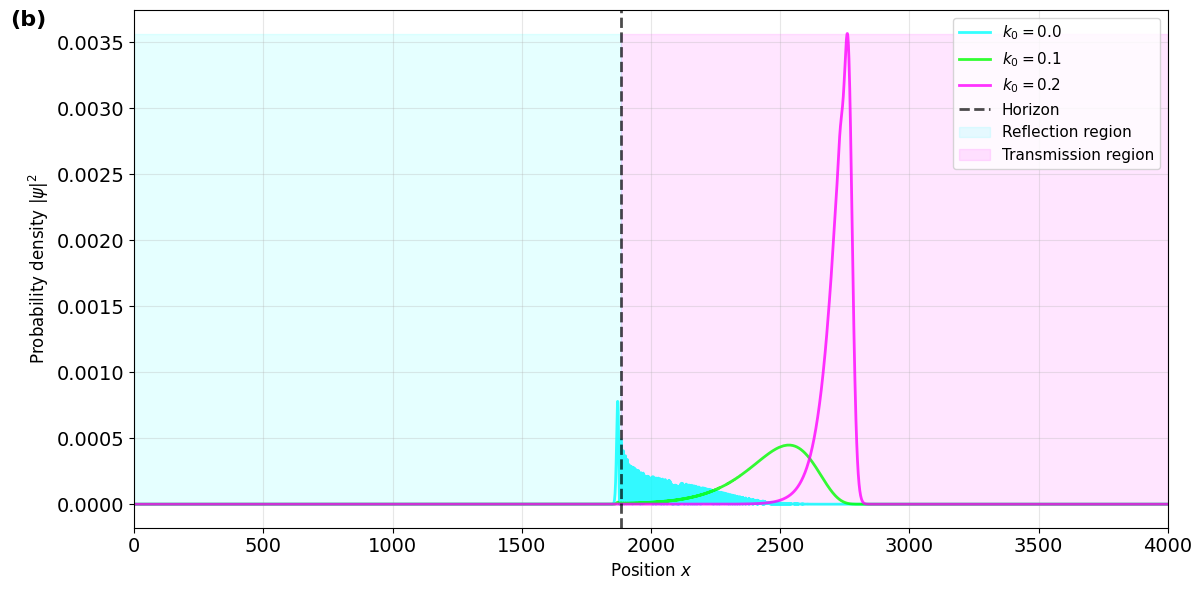

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


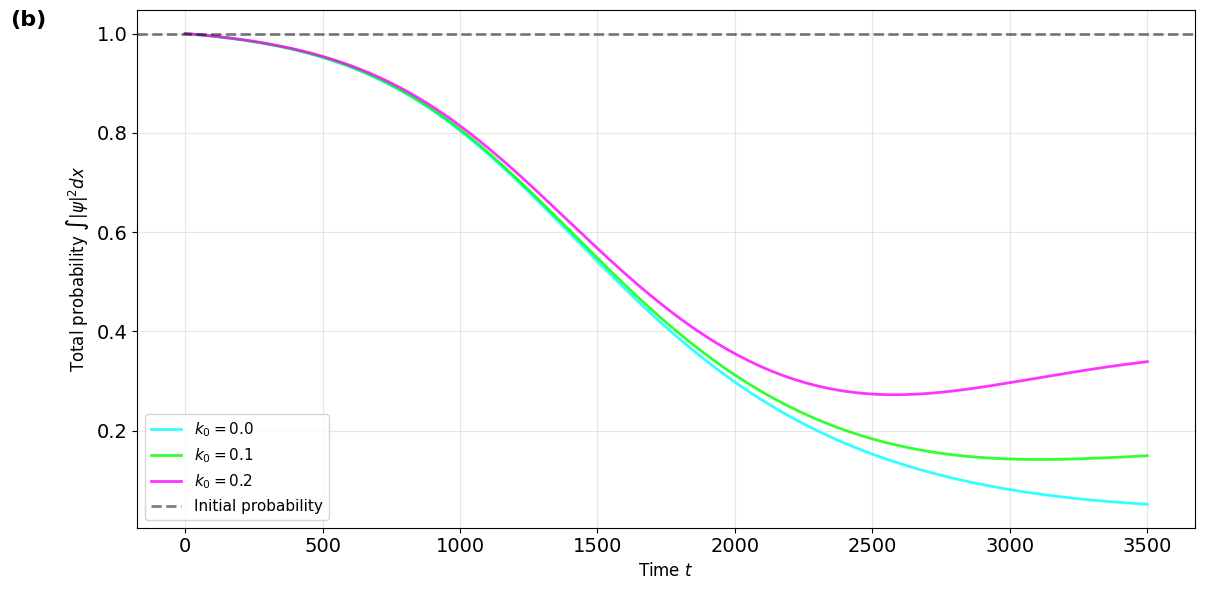

In [6]:
# ===== Final Wavefunction Spatial Distribution =====
fig, ax = plt.subplots(figsize=(12, 6))

for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    ax.plot(x, final_density, color=colors[i], linewidth=2, label=f'$k_0 = {k0:.1f}$', alpha=0.8)

# Mark horizon
ax.axvline(x=x_horizon, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Horizon')
ax.fill_betweenx([0, np.max([np.max(np.abs(results[k0]['final_psi'])**2) for k0 in k0_values])], 0, x_horizon, color='cyan', alpha=0.1, label='Reflection region')
ax.fill_betweenx([0, np.max([np.max(np.abs(results[k0]['final_psi'])**2) for k0 in k0_values])], x_horizon, L, color='magenta', alpha=0.1, label='Transmission region')

ax.set_xlabel('Position $x$', fontsize=12)
ax.set_ylabel('Probability density $|\\psi|^2$', fontsize=12)
#ax.set_title('Final Wave Packet Distribution (Model 2)', fontsize=13)
ax.legend(fontsize=11, loc='upper right')
ax.grid(alpha=0.3)
ax.set_xlim([0, L])
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.annotate('(b)', xy=(-0.12, 1.00), xycoords='axes fraction',
             fontsize=16, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.savefig('E2_scattering_coefficients.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# ===== Probability Evolution Over Time =====
fig, ax = plt.subplots(figsize=(12, 6))

for i, k0 in enumerate(k0_values):
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    ax.plot(time_array, prob_array, color=colors[i], linewidth=2, 
            label=f'$k_0 = {k0:.1f}$', alpha=0.8)

ax.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Initial probability')
ax.set_xlabel('Time $t$', fontsize=12)
ax.set_ylabel('Total probability $\\int|\\psi|^2 dx$', fontsize=12)
#ax.set_title('Probability Evolution (Non-Hermitian Evolution)\nModel 2 (Tilt + Dispersion)', fontsize=13)
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.annotate('(b)', xy=(-0.12, 1.00), xycoords='axes fraction',
             fontsize=16, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.savefig('E2_probability_evolution.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


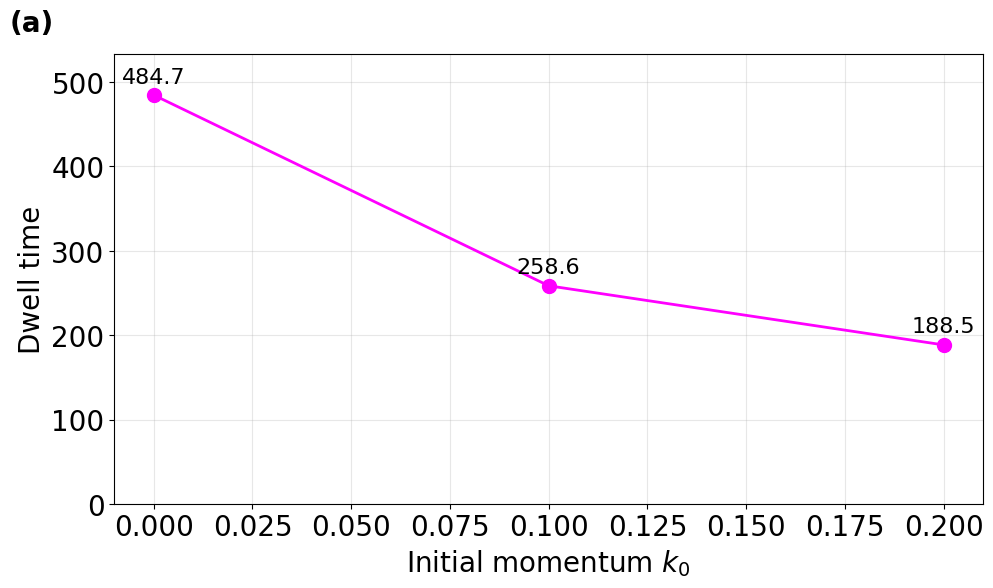

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


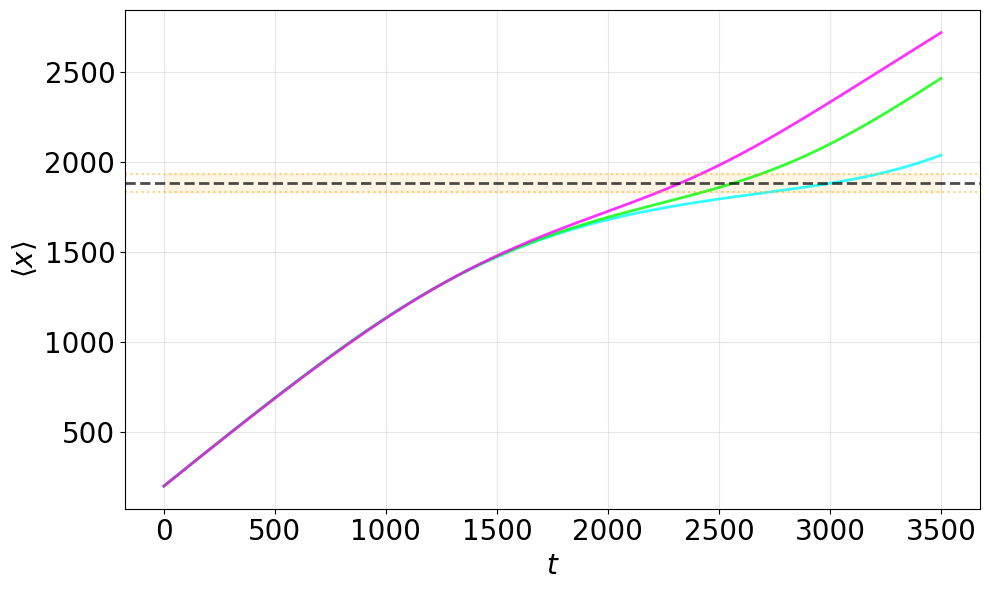


===== Horizon Properties =====
Horizon position: x_h = 1884.51

===== Non-Hermitian Absorption Summary =====
Model 2 probability loss characteristics:
  k0 = 0.0: 94.9% absorbed
  k0 = 0.1: 85.1% absorbed
  k0 = 0.2: 66.1% absorbed
DWELL TIME ANALYSIS - MODEL 1 (Pure Tilt)
k₀       Total Dwell  Entries  Avg/Entry  Max Dwell  Still Dwelling  Closest Approach
--------------------------------------------------------------------------------
0.0      484.7        1        484.7      484.7      No              0.0            
0.1      258.6        1        258.6      258.6      No              0.0            
0.2      188.5        1        188.5      188.5      No              0.0            

DETAILED TIMELINE ANALYSIS:
--------------------------------------------------

k₀ = 0.0:
  Passage 1:
    Time: 2732.2 → 3216.8 (duration: 484.7)
    Position: 1834.5 → 1934.5
    Horizon distance: 50.0 → 50.0
  Overall range: 200.0 → 2039.2
  Maximum horizon approach: 0.0

k₀ = 0.1:
  Passage 1:
   

In [7]:
# Plot 1: Dwell time vs k0 (Individual)
plt.figure(figsize=(10, 6))
plt.plot(k0_values, dwell_times, 'o-', color='magenta', linewidth=2, markersize=10)
plt.xlabel('Initial momentum $k_0$', fontsize=20)
plt.ylabel('Dwell time', fontsize=20)
#plt.title('Horizon Dwell Time vs Initial Momentum\nModel 2 (Tilt + Dispersion)', fontsize=13)
plt.grid(alpha=0.3)
plt.ylim([0, max(dwell_times) * 1.1 if dwell_times else 1])
plt.tick_params(axis='both', which='major', labelsize=20)

# Add plot label
plt.text(-0.12, 1.1, '(a)', transform=plt.gca().transAxes,
         fontsize=20, fontweight='bold', va='top')

# Add text annotations
for i, (k0, dwell) in enumerate(zip(k0_values, dwell_times)):
    plt.text(k0, dwell + (max(dwell_times) if dwell_times else 1)*0.03, f'{dwell:.1f}', 
             ha='center', fontsize=16, color='black')

plt.tight_layout()
plt.savefig('E2_dwell_time_vs_k0.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# Plot 2: Trajectory showing dwell region (Individual)
plt.figure(figsize=(10, 6))
for i, k0 in enumerate(k0_values):
    x_c_array = np.array(results[k0]['x_c_list'])
    time_array = np.array(results[k0]['time_list'])
    plt.plot(time_array, x_c_array, color=colors[i], linewidth=2, 
             label=f'$k_0 = {k0:.1f}$', alpha=0.8)

# Mark horizon and dwell region
plt.axhline(y=x_horizon, color='black', linestyle='--', linewidth=2, 
            alpha=0.7, label='Horizon')
plt.axhline(y=x_horizon + dwell_threshold, color='orange', linestyle=':', 
            linewidth=1.5, alpha=0.5, label=f'Dwell region (±{dwell_threshold})')
plt.axhline(y=x_horizon - dwell_threshold, color='orange', linestyle=':', 
            linewidth=1.5, alpha=0.5)
plt.fill_between(time_array, x_horizon - dwell_threshold, 
                 x_horizon + dwell_threshold, color='orange', alpha=0.1)

plt.xlabel('$t$', fontsize=20)
plt.ylabel('$\\langle x \\rangle$', fontsize=20)
#plt.title('Wave Packet Trajectory (Model 2)', fontsize=13)
#plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=20)

# Add plot label
#plt.text(-0.12, 1.1, '(b)', transform=plt.gca().transAxes,
 #        fontsize=20, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('E2_wave_packet_trajectories.eps', format='eps', dpi=600, bbox_inches='tight')
plt.savefig('E2_wave_packet_trajectories.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

print("\n===== Horizon Properties =====")
print(f"Horizon position: x_h = {x_horizon:.2f}")
print("\n===== Non-Hermitian Absorption Summary =====")
print(f"Model 2 probability loss characteristics:")
for k0, loss in zip(k0_values, Loss_values):
    print(f"  k0 = {k0:.1f}: {loss*100:.1f}% absorbed")


# Dwell Time Diagnostic - Model 1
print("=" * 60)
print("DWELL TIME ANALYSIS - MODEL 1 (Pure Tilt)")
print("=" * 60)

print(f"{'k₀':<8} {'Total Dwell':<12} {'Entries':<8} {'Avg/Entry':<10} {'Max Dwell':<10} {'Still Dwelling':<15} {'Closest Approach':<15}")
print("-" * 80)

for i, k0 in enumerate(k0_values):
    dwell_data = results[k0]
    total_dwell = dwell_data['dwell_time']
    entries = dwell_data['dwell_entries']
    num_entries = len(entries)
    
    if num_entries > 0:
        avg_dwell = np.mean([exit_t - enter_t for enter_t, exit_t in entries])
        max_dwell = max([exit_t - enter_t for enter_t, exit_t in entries])
    else:
        avg_dwell = 0
        max_dwell = 0
        
    still_dwelling = "Yes" if dwell_data['still_dwelling'] else "No"
    
    # Find closest approach to horizon
    x_c_list = dwell_data['x_c_list']
    if len(x_c_list) > 0:
        min_distance = min([abs(x - x_horizon) for x in x_c_list])
        closest_idx = np.argmin([abs(x - x_horizon) for x in x_c_list])
        closest_time = closest_idx * dt
    else:
        min_distance = float('inf')
        closest_time = 0
    
    print(f"{k0:<8.1f} {total_dwell:<12.1f} {num_entries:<8} {avg_dwell:<10.1f} {max_dwell:<10.1f} {still_dwelling:<15} {min_distance:<15.1f}")

print()
print("DETAILED TIMELINE ANALYSIS:")
print("-" * 50)

for k0 in k0_values:
    dwell_data = results[k0]
    entries = dwell_data['dwell_entries']
    x_c_list = dwell_data['x_c_list']
    time_list = dwell_data['time_list']
    
    print(f"\nk₀ = {k0:.1f}:")
    
    if len(entries) > 0:
        for i, (enter_t, exit_t) in enumerate(entries):
            duration = exit_t - enter_t
            # Find position at entry and exit
            enter_idx = int(enter_t / dt)
            exit_idx = int(exit_t / dt)
            enter_pos = x_c_list[enter_idx] if enter_idx < len(x_c_list) else 0
            exit_pos = x_c_list[exit_idx] if exit_idx < len(x_c_list) else 0
            
            print(f"  Passage {i+1}:")
            print(f"    Time: {enter_t:.1f} → {exit_t:.1f} (duration: {duration:.1f})")
            print(f"    Position: {enter_pos:.1f} → {exit_pos:.1f}")
            print(f"    Horizon distance: {abs(enter_pos - x_horizon):.1f} → {abs(exit_pos - x_horizon):.1f}")
    else:
        print(f"  No horizon entries")
    
    # Overall statistics
    if len(x_c_list) > 0:
        max_reach = max(x_c_list)
        min_reach = min(x_c_list)
        print(f"  Overall range: {min_reach:.1f} → {max_reach:.1f}")
        print(f"  Maximum horizon approach: {min([abs(x - x_horizon) for x in x_c_list]):.1f}")

print()
print("PHYSICS INTERPRETATION:")
print("-" * 50)
print("Expected pattern for Model 1:")
print("- k₀ = 0.0: Long single dwell period near horizon")
print("- k₀ = 0.1: Shorter dwell, stops further from horizon") 
print("- k₀ = 0.2: Minimal dwell, stops well before horizon")
print("- All: Single horizon passage (reflection only)")
print("=" * 60)

In [8]:
for k0 in k0_values:
    dwell_entries = results[k0]['dwell_entries']
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    if len(dwell_entries) > 0:
        for j, (t_in, t_out) in enumerate(dwell_entries):
            # Find probability at dwell entry and exit
            idx_in = np.argmin(np.abs(time_array - t_in))
            idx_out = np.argmin(np.abs(time_array - t_out))
            P_in = prob_array[idx_in]
            P_out = prob_array[idx_out]
            
            print(f"k0 = {k0:.1f}, Dwell period {j+1}:")
            print(f"  Entry: t={t_in:.0f}, P={P_in:.6f}")
            print(f"  Exit: t={t_out:.0f}, P={P_out:.6f}")
            print(f"  Change: ΔP = {P_out - P_in:+.6f}")
            if P_out > P_in:
                print(f"  ⚠️ Probability GREW during dwell (unphysical!)")

# Check all three k0 values
for k0 in k0_values:
    dwell_entries = results[k0]['dwell_entries']
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    print(f"\n===== k0 = {k0:.1f} =====")
    print(f"Number of dwell periods: {len(dwell_entries)}")
    
    if len(dwell_entries) > 0:
        for j, (t_in, t_out) in enumerate(dwell_entries):
            idx_in = np.argmin(np.abs(time_array - t_in))
            idx_out = np.argmin(np.abs(time_array - t_out))
            P_in = prob_array[idx_in]
            P_out = prob_array[idx_out]
            duration = t_out - t_in
            
            print(f"Dwell period {j+1}:")
            print(f"  Duration: {duration:.0f}")
            print(f"  Entry: t={t_in:.0f}, P={P_in:.6f}")
            print(f"  Exit: t={t_out:.0f}, P={P_out:.6f}")
            print(f"  Change: ΔP = {P_out - P_in:+.6f} ({(P_out/P_in - 1)*100:+.1f}%)")
    else:
        print("  No dwell periods detected")

k0 = 0.0, Dwell period 1:
  Entry: t=2732, P=0.112279
  Exit: t=3217, P=0.064407
  Change: ΔP = -0.047872
k0 = 0.1, Dwell period 1:
  Entry: t=2430, P=0.194974
  Exit: t=2689, P=0.159343
  Change: ΔP = -0.035631
k0 = 0.2, Dwell period 1:
  Entry: t=2230, P=0.300559
  Exit: t=2418, P=0.277749
  Change: ΔP = -0.022810

===== k0 = 0.0 =====
Number of dwell periods: 1
Dwell period 1:
  Duration: 485
  Entry: t=2732, P=0.112279
  Exit: t=3217, P=0.064407
  Change: ΔP = -0.047872 (-42.6%)

===== k0 = 0.1 =====
Number of dwell periods: 1
Dwell period 1:
  Duration: 259
  Entry: t=2430, P=0.194974
  Exit: t=2689, P=0.159343
  Change: ΔP = -0.035631 (-18.3%)

===== k0 = 0.2 =====
Number of dwell periods: 1
Dwell period 1:
  Duration: 188
  Entry: t=2230, P=0.300559
  Exit: t=2418, P=0.277749
  Change: ΔP = -0.022810 (-7.6%)



GROUP VELOCITY DIAGNOSTIC ANALYSIS

--- Analysis for k0 = 0.0 ---
Allowed Region (x < 1835):
  Mean v_g = 0.598262 ± 0.304694
  Range: 0.165279 to 0.999803
  Time spent: 2732.05
Horizon Region (x = 1884.5143010338384 ± 50):
  Mean v_g = 0.206316 ± 0.035348
  Minimum v_g = 0.165758
  Range: 0.165758 to 0.286059
  Time spent: 484.60
  → SLOWS but continues (min v_g = 0.165758)
Forbidden Region (x > 1935):
  Mean v_g = 0.369682 ± 0.051435
  Range: 0.286084 to 0.462820
  Time spent: 283.15
  → SUCCESSFUL TRANSMISSION detected
Transmission Probability: T = 0.0424
Reflection Probability: R = 0.0091
  → WEAK TRANSMISSION (1% < T < 10%)

--- Analysis for k0 = 0.1 ---
Allowed Region (x < 1835):
  Mean v_g = 0.672635 ± 0.252918
  Range: 0.318400 to 0.998534
  Time spent: 2429.95
Horizon Region (x = 1884.5143010338384 ± 50):
  Mean v_g = 0.386694 ± 0.029968
  Minimum v_g = 0.341700
  Range: 0.341700 to 0.444500
  Time spent: 258.55
  → SLOWS but continues (min v_g = 0.341700)
Forbidden Region (x

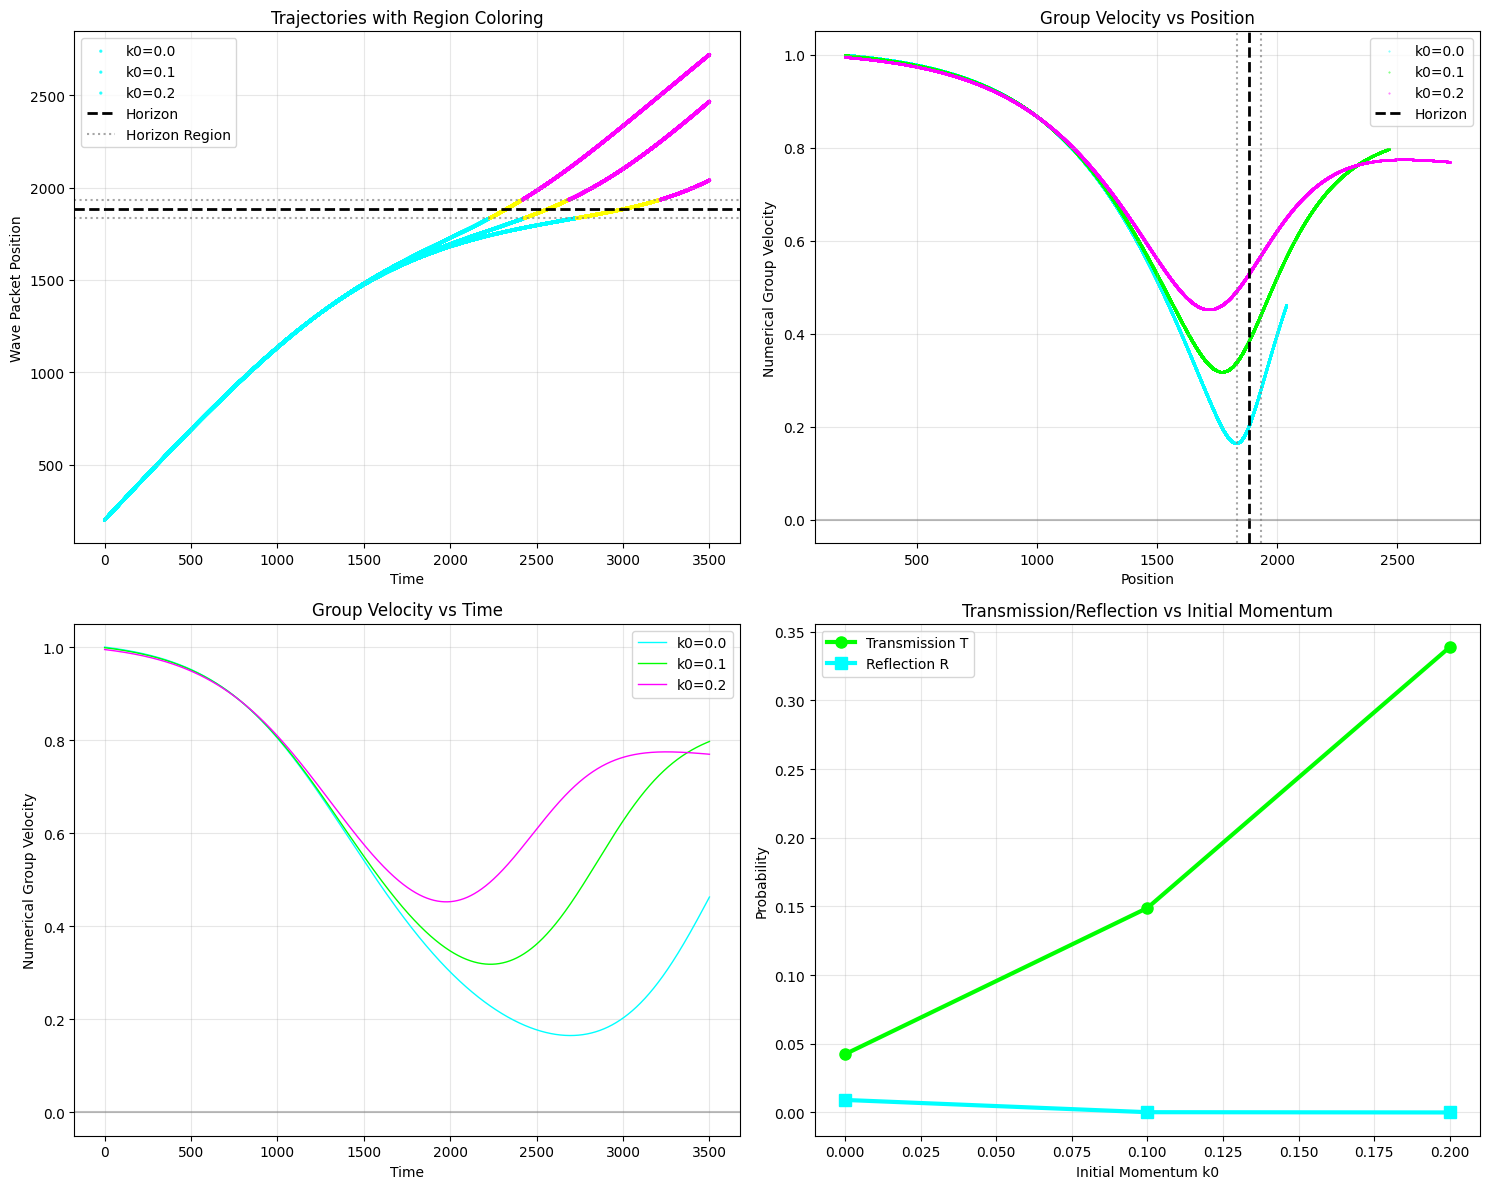

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



SUMMARY OF KEY FINDINGS:
Horizon position: x = 1884.5
Horizon region: x = 1884.5143010338384 ± 50

k0 = 0.0: T = 0.0424, R = 0.0091

k0 = 0.1: T = 0.1489, R = 0.0002

k0 = 0.2: T = 0.3388, R = 0.0000


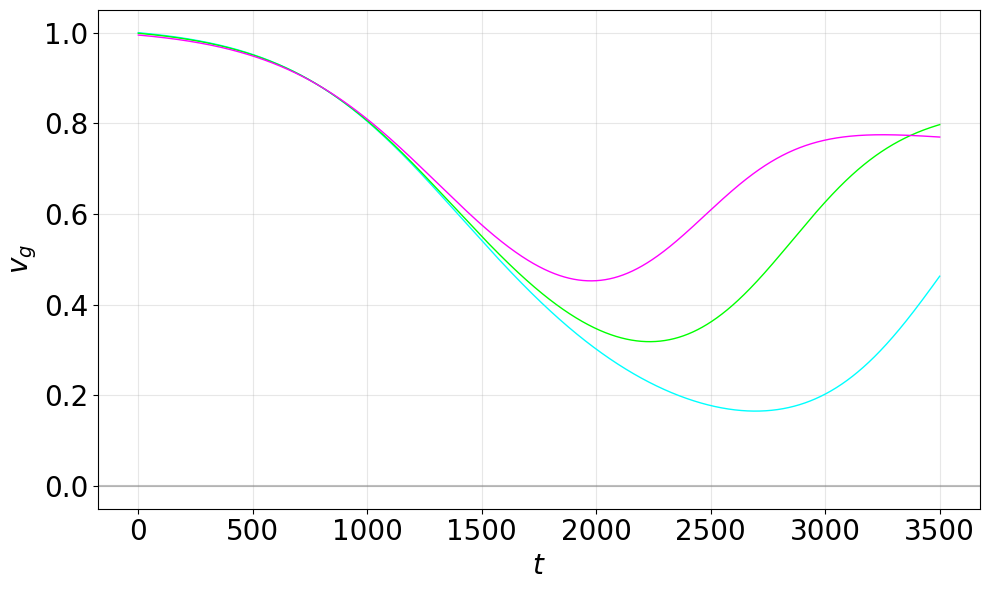

In [9]:
#Group Velocity Diagnostic Analysis
print("\n" + "="*60)
print("GROUP VELOCITY DIAGNOSTIC ANALYSIS")
print("="*60)

for i, k0 in enumerate(k0_values):
    print(f"\n--- Analysis for k0 = {k0} ---")
    
    # Get numerical trajectory data
    x_c_list = results[k0]['x_c_list']
    time_list = results[k0]['time_list']
    vg_num_list = results[k0]['vg_num']
    
    # Define regions
    horizon_region = (x_horizon - horizon_interaction_width, x_horizon + horizon_interaction_width)
    allowed_region = (0, x_horizon - horizon_interaction_width)
    forbidden_region = (x_horizon + horizon_interaction_width, L)
    
    # Analyze group velocity in each region
    vg_allowed = []
    vg_horizon = [] 
    vg_forbidden = []
    times_allowed = []
    times_horizon = []
    times_forbidden = []
    
    for j, (x_pos, time_val) in enumerate(zip(x_c_list[1:], time_list[1:])):
        if j < len(vg_num_list):
            vg = vg_num_list[j]
            
            if allowed_region[0] <= x_pos <= allowed_region[1]:
                vg_allowed.append(vg)
                times_allowed.append(time_val)
            elif horizon_region[0] <= x_pos <= horizon_region[1]:
                vg_horizon.append(vg)
                times_horizon.append(time_val)
            elif forbidden_region[0] <= x_pos <= forbidden_region[1]:
                vg_forbidden.append(vg)
                times_forbidden.append(time_val)
    
    # Calculate statistics
    if vg_allowed:
        vg_allowed_mean = np.mean(vg_allowed)
        vg_allowed_std = np.std(vg_allowed)
        print(f"Allowed Region (x < {x_horizon-horizon_interaction_width:.0f}):")
        print(f"  Mean v_g = {vg_allowed_mean:.6f} ± {vg_allowed_std:.6f}")
        print(f"  Range: {min(vg_allowed):.6f} to {max(vg_allowed):.6f}")
        print(f"  Time spent: {max(times_allowed)-min(times_allowed) if times_allowed else 0:.2f}")
    
    if vg_horizon:
        vg_horizon_mean = np.mean(vg_horizon)
        vg_horizon_std = np.std(vg_horizon)
        vg_horizon_min = min(vg_horizon)
        print(f"Horizon Region (x = {x_horizon} ± {horizon_interaction_width}):")
        print(f"  Mean v_g = {vg_horizon_mean:.6f} ± {vg_horizon_std:.6f}")
        print(f"  Minimum v_g = {vg_horizon_min:.6f}")
        print(f"  Range: {min(vg_horizon):.6f} to {max(vg_horizon):.6f}")
        print(f"  Time spent: {max(times_horizon)-min(times_horizon) if times_horizon else 0:.2f}")
        
        # Check if wave packet actually stops or just slows down
        if abs(vg_horizon_min) < 1e-3:
            print(f"  → NEARLY STOPS at horizon (v_g ≈ {vg_horizon_min:.6f})")
        else:
            print(f"  → SLOWS but continues (min v_g = {vg_horizon_min:.6f})")
    
    if vg_forbidden:
        vg_forbidden_mean = np.mean(vg_forbidden)
        vg_forbidden_std = np.std(vg_forbidden)
        print(f"Forbidden Region (x > {x_horizon+horizon_interaction_width:.0f}):")
        print(f"  Mean v_g = {vg_forbidden_mean:.6f} ± {vg_forbidden_std:.6f}")
        print(f"  Range: {min(vg_forbidden):.6f} to {max(vg_forbidden):.6f}")
        print(f"  Time spent: {max(times_forbidden)-min(times_forbidden) if times_forbidden else 0:.2f}")
        
        # Check if transmission occurred
        if len(vg_forbidden) > 10:  # Significant time spent in forbidden region
            print(f"  → SUCCESSFUL TRANSMISSION detected")
    
    # Transmission analysis
    T = T_values[i]
    R = R_values[i]
    print(f"Transmission Probability: T = {T:.4f}")
    print(f"Reflection Probability: R = {R:.4f}")
    
    if T > 0.1:
        print(f"  → SIGNIFICANT TRANSMISSION (T > 10%)")
    elif T > 0.01:
        print(f"  → WEAK TRANSMISSION (1% < T < 10%)")
    else:
        print(f"  → PRIMARILY REFLECTION (T < 1%)")

# ===== Plot Group Velocity Analysis =====
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Trajectories with region coloring
ax1 = axes[0, 0]
for i, k0 in enumerate(k0_values):
    x_c_list = results[k0]['x_c_list']
    time_list = results[k0]['time_list']
    
    # Color code by region
    colors_regions = []
    for x_pos in x_c_list:
        if x_pos < x_horizon - horizon_interaction_width:
            colors_regions.append('cyan')  # Allowed
        elif x_pos > x_horizon + horizon_interaction_width:
            colors_regions.append('magenta')  # Forbidden  
        else:
            colors_regions.append('yellow')  # Horizon
    
    scatter = ax1.scatter(time_list, x_c_list, c=colors_regions, s=2, alpha=0.7, label=f'k0={k0}')
    
ax1.axhline(y=x_horizon, color='black', linestyle='--', linewidth=2, label='Horizon')
ax1.axhline(y=x_horizon - horizon_interaction_width, color='gray', linestyle=':', alpha=0.7, label='Horizon Region')
ax1.axhline(y=x_horizon + horizon_interaction_width, color='gray', linestyle=':', alpha=0.7)
ax1.set_xlabel('Time')
ax1.set_ylabel('Wave Packet Position')
ax1.set_title('Trajectories with Region Coloring')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Group velocity vs position
ax2 = axes[0, 1]
for i, k0 in enumerate(k0_values):
    x_c_list = results[k0]['x_c_list'][1:]  # Skip first point (no v_g)
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(x_c_list):
        ax2.scatter(x_c_list, vg_num_list, color=colors[i], s=0.2, alpha=0.6, label=f'k0={k0}')
    
ax2.axvline(x=x_horizon, color='black', linestyle='--', linewidth=2, label='Horizon')
ax2.axvline(x=x_horizon - horizon_interaction_width, color='gray', linestyle=':', alpha=0.7)
ax2.axvline(x=x_horizon + horizon_interaction_width, color='gray', linestyle=':', alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax2.set_xlabel('Position')
ax2.set_ylabel('Numerical Group Velocity')
ax2.set_title('Group Velocity vs Position')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Group velocity vs time
ax3 = axes[1, 0]
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]  # Skip first point
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(time_list):
        ax3.plot(time_list, vg_num_list, color=colors[i], linewidth=1, label=f'k0={k0}')
    
ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax3.set_xlabel('Time')
ax3.set_ylabel('Numerical Group Velocity')
ax3.set_title('Group Velocity vs Time')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Transmission vs initial momentum
ax4 = axes[1, 1]
ax4.plot(k0_values, T_values, 'o-', color='lime', linewidth=3, markersize=8, label='Transmission T')
ax4.plot(k0_values, R_values, 's-', color='cyan', linewidth=3, markersize=8, label='Reflection R')
ax4.set_xlabel('Initial Momentum k0')
ax4.set_ylabel('Probability')
ax4.set_title('Transmission/Reflection vs Initial Momentum')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY OF KEY FINDINGS:")
print("="*60)
print(f"Horizon position: x = {x_horizon:.1f}")
print(f"Horizon region: x = {x_horizon} ± {horizon_interaction_width}")


for i, k0 in enumerate(k0_values):
    print(f"\nk0 = {k0}: T = {T_values[i]:.4f}, R = {R_values[i]:.4f}")

# Plot 3: Group velocity vs time
plt.figure(figsize=(10, 6))
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]  # Skip first point
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(time_list):
        plt.plot(time_list, vg_num_list, color=colors[i], linewidth=1, label=f'k0={k0}')
    
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$v_g$', fontsize=20)
#plt.set_title('Group Velocity vs Time')
#ax3.legend()
plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('E2_vg(t).eps', format='eps', dpi=600, bbox_inches='tight')
plt.savefig('E2_vg(t).png', format='png', dpi=600, bbox_inches='tight')
plt.show()


TILT POTENTIAL VALUES - MODEL 2
Position (x) V(x)       Description         
--------------------------------------------------
200          0.0000      INITIAL POSITION
1500         0.4878      ALLOWED REGION
1600         0.6033      ALLOWED REGION
1700         0.7321      ALLOWED REGION
1800         0.8707      ALLOWED REGION
1884.5143010338384 0.9919      HORIZON
1900         1.0142      FORBIDDEN REGION
2000         1.1567      FORBIDDEN REGION
2100         1.2928      FORBIDDEN REGION
2200         1.4178      FORBIDDEN REGION
2300         1.5286      FORBIDDEN REGION
2400         1.6239      FORBIDDEN REGION
2500         1.7037      FORBIDDEN REGION
2600         1.7689      FORBIDDEN REGION
2700         1.8212      FORBIDDEN REGION
2800         1.8626      FORBIDDEN REGION
2900         1.8950      FORBIDDEN REGION
3000         1.9200      FORBIDDEN REGION
3100         1.9393      FORBIDDEN REGION
3200         1.9541      FORBIDDEN REGION
3300         1.9653      FORBIDDEN REGION


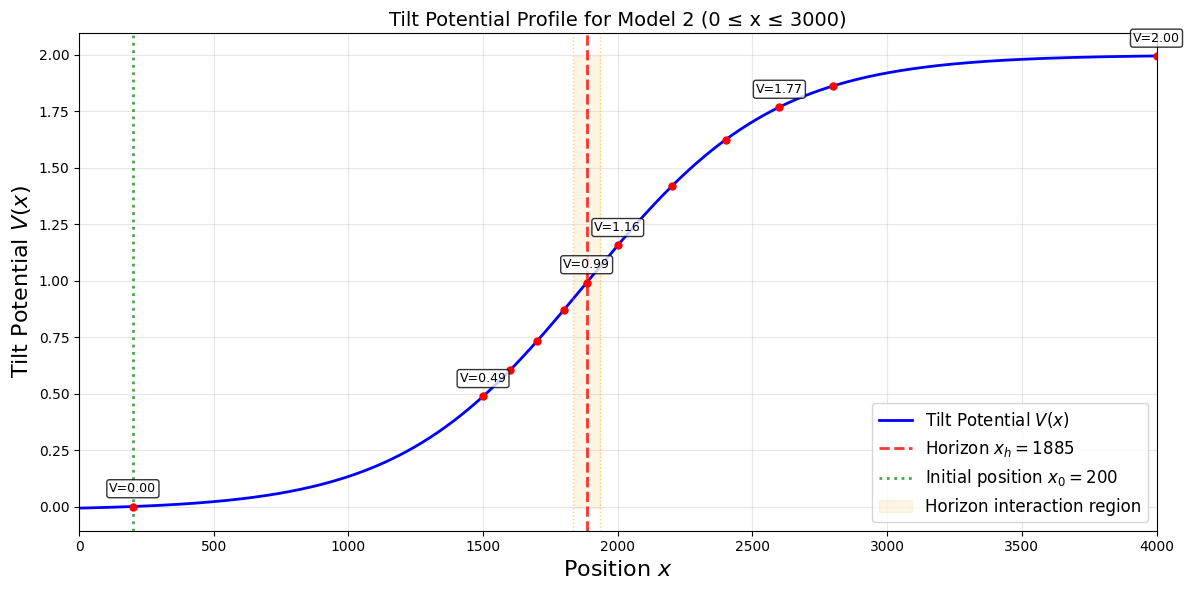

In [10]:
# Calculate the tilt potential V(x) function
def calculate_V(x_pos):
    V_norm = np.tanh((x0 - x_horizon)/a)
    return t_max * (np.tanh((x_pos - x_horizon)/a) - V_norm) / (1 - V_norm)

# Print V(x) values at specific positions
print("\n" + "="*60)
print("TILT POTENTIAL VALUES - MODEL 2")
print("="*60)
print(f"{'Position (x)':<12} {'V(x)':<10} {'Description':<20}")
print("-" * 50)

# Print values from 1500 to 3000 in increments of 100, plus horizon and key positions
positions_to_print = list(range(1500, 4001, 100))
positions_to_print.extend([x0, x_horizon])  # Add initial position and horizon
positions_to_print = sorted(set(positions_to_print))  # Remove duplicates and sort

for pos in positions_to_print:
    v_val = calculate_V(pos)
    
    # Add description
    if pos == x_horizon:
        desc = "HORIZON"
    elif pos == x0:
        desc = "INITIAL POSITION"
    elif pos < x_horizon:
        desc = "ALLOWED REGION"
    else:
        desc = "FORBIDDEN REGION"
    
    print(f"{pos:<12} {v_val:<10.4f}  {desc}")

# Additional information
print("\n" + "="*50)
print("KEY POTENTIAL INFORMATION")
print("="*50)
print(f"Potential range: V_min = {calculate_V(0):.4f}, V_max = {calculate_V(L-1):.4f}")
print(f"Horizon position: x_h = {x_horizon:.1f}")
print(f"Initial position: x_0 = {x0:.1f}")
print(f"Potential at horizon: V(x_h) = {calculate_V(x_horizon):.4f}")
print(f"Potential at initial position: V(x_0) = {calculate_V(x0):.4f}")
print(f"Horizon interaction width: ±{horizon_interaction_width}")
print(f"Potential at interaction boundaries:")
print(f"  V(x_h - {horizon_interaction_width}) = {calculate_V(x_horizon - horizon_interaction_width):.4f}")
print(f"  V(x_h + {horizon_interaction_width}) = {calculate_V(x_horizon + horizon_interaction_width):.4f}")

# Plot the tilt potential (corrected version)
plt.figure(figsize=(12, 6))

# Create x values for plotting
x_plot = np.linspace(0, 4000, 1000)
V_plot = calculate_V(x_plot)

plt.plot(x_plot, V_plot, 'b-', linewidth=2, label='Tilt Potential $V(x)$')

# Mark important positions
plt.axvline(x=x_horizon, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Horizon $x_h = {x_horizon:.0f}$')
plt.axvline(x=x0, color='green', linestyle=':', linewidth=2, alpha=0.7, label=f'Initial position $x_0 = {x0:.0f}$')

# Mark horizon interaction region
plt.axvline(x=x_horizon - horizon_interaction_width, color='orange', linestyle=':', linewidth=1, alpha=0.5)
plt.axvline(x=x_horizon + horizon_interaction_width, color='orange', linestyle=':', linewidth=1, alpha=0.5)
plt.fill_between(x_plot, min(V_plot), max(V_plot), 
                 where=(x_plot >= x_horizon - horizon_interaction_width) & 
                       (x_plot <= x_horizon + horizon_interaction_width),
                 color='orange', alpha=0.1, label='Horizon interaction region')

# Add key V(x) values as annotations
key_positions = [1500, 1600, 1700, 1800, x_horizon, 2000, 2200, 2400, 2600, 2800, 4000, x0]

for pos in key_positions:
    if 0 <= pos <= 4000:
        v_val = calculate_V(pos)
        plt.plot(pos, v_val, 'ro', markersize=5)
        # Only label key positions to reduce clutter
        if pos in [1500, x0, x_horizon, 2000, 2600, 4000]:
            plt.text(pos, v_val + 0.05, f'V={v_val:.2f}', 
                    fontsize=9, ha='center', va='bottom', 
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

plt.xlabel('Position $x$', fontsize=16)
plt.ylabel('Tilt Potential $V(x)$', fontsize=16)
plt.title('Tilt Potential Profile for Model 2 (0 ≤ x ≤ 3000)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([0, 4000])

plt.tight_layout()
plt.savefig('E2_tilt_potential_extended.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()